### 目标

发现维基百科中的**故意破坏者**，他们故意污染词条。

### 数据

**Language**词条的历史修订版本。若一个版本被还原，则认为该版本是破坏者。

- Vandal：破坏者
- Minor：小众词条
- Loggedin：编辑者是否登录
- Added：The unique words added
- Removed： The unique words removed

In [1]:
wiki = read.csv("./data/wiki.csv", stringsAsFactors=FALSE)
wiki$Vandal = as.factor(wiki$Vandal)

In [2]:
table(wiki$Vandal)


   0    1 
2061 1815 

In [2]:
library(tm)

Loading required package: NLP


In [3]:
corpusAdded = Corpus(VectorSource(wiki$Added))
corpusAdded = tm_map(corpusAdded, removeWords, stopwords("english"))
corpusAdded = tm_map(corpusAdded, stemDocument)
dtmAdded = DocumentTermMatrix(corpusAdded)
dtmAdded

<<DocumentTermMatrix (documents: 3876, terms: 6675)>>
Non-/sparse entries: 15368/25856932
Sparsity           : 100%
Maximal term length: 784
Weighting          : term frequency (tf)

In [4]:
sparseAdded = removeSparseTerms(dtmAdded, 0.997)
sparseAdded

<<DocumentTermMatrix (documents: 3876, terms: 166)>>
Non-/sparse entries: 2681/640735
Sparsity           : 100%
Maximal term length: 28
Weighting          : term frequency (tf)

In [5]:
wordsAdded = as.data.frame(as.matrix(sparseAdded))
colnames(wordsAdded) = paste("A", colnames(wordsAdded))

In [6]:
corpusRemoved = Corpus(VectorSource(wiki$Removed))
corpusRemoved = tm_map(corpusRemoved, removeWords, stopwords("english"))
corpusRemoved = tm_map(corpusRemoved, stemDocument)

In [7]:
dtmRemoved = DocumentTermMatrix(corpusRemoved)
sparseRemoved = removeSparseTerms(dtmRemoved, 0.997)
wordsRemoved = as.data.frame(as.matrix(sparseRemoved))
colnames(wordsRemoved) = paste("R", colnames(wordsRemoved))

In [10]:
str(wordsRemoved)

'data.frame':	3876 obs. of  162 variables:
 $ R 2000000                     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R 40000                       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R accord                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R actual                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R ago                         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R agre                        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R analog                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R appar                       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R arbitrari                   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R believ                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R bigger                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R biolog                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R biologyanalog               : num  0 0 0 0 0 0 0 0 0 0 ...
 $ R bodi                        : num  0 0 0 1 0 0 0 0 0 0 ...
 $ R call                        : num  0 0 0 1 0 0 0 0 0 0 .

In [11]:
wikiWords = cbind(wordsAdded, wordsRemoved)

In [12]:
wikiWords$Vandal = wiki$Vandal

In [13]:
library(caTools)
set.seed(123)
split = sample.split(wikiWords$Vandal, SplitRatio=0.7)
train = subset(wikiWords, split==TRUE)
test = subset(wikiWords, split==FALSE)

In [14]:
table(test$Vandal)


  0   1 
618 545 

In [15]:
618/(618+545)

[1] 0.5313844

In [16]:
library(rpart)
library(rpart.plot)

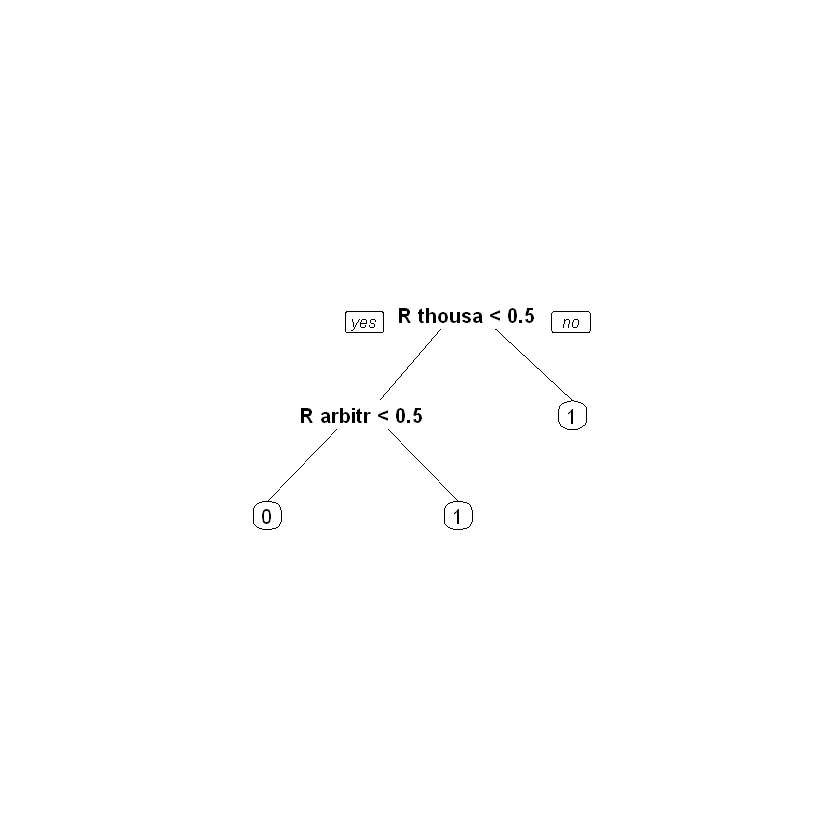

In [18]:
wikiCART = rpart(Vandal ~ ., data=train, method="class")
prp(wikiCART)

In [19]:
predictCART = predict(wikiCART, newdata=test, type="class")
table(test$Vandal, predictCART)

   predictCART
      0   1
  0 618   0
  1 533  12

In [20]:
(618+12)/(618+533+12)

[1] 0.5417025

The words themselves were not useful. 向词条编辑入网址是一种常见的破坏行为，现在假设网址的出现是破坏行为的标识。

In [21]:
wikiWords2 = wikiWords
wikiWords2$HTTP = ifelse(grepl("http",wiki$Added, fixed=TRUE),1,0)
table(wikiWords2$HTTP)


   0    1 
3659  217 

In [22]:
train2 = subset(wikiWords2, split==TRUE)
test2 = subset(wikiWords2, split==FALSE)

In [23]:
wikiCART2 = rpart(Vandal ~ ., data=train2, method="class")
predictCART2 = predict(wikiCART2, newdata=test2, type="class")
table(test2$Vandal, predictCART2)

   predictCART2
      0   1
  0 609   9
  1 488  57

In [24]:
(609+57)/(609+9+488+57)

[1] 0.5726569

假设加入、移除的单词数量（而非加入、移除行为本身）是更好的标识。

In [25]:
wikiWords2$NumWordsAdded = rowSums(as.matrix(dtmAdded))
wikiWords2$NumWordsRemoved = rowSums(as.matrix(dtmRemoved))

In [29]:
summary(wikiWords2$NumWordsAdded)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00    4.05    3.00  259.00 

In [30]:
train3 = subset(wikiWords2, split==TRUE)
test3 = subset(wikiWords2, split==FALSE)
wikiCART3 = rpart(Vandal ~ ., data=train3, method="class")
predictCART3 = predict(wikiCART3, newdata=test3, type="class")
table(test3$Vandal, predictCART3)

   predictCART3
      0   1
  0 514 104
  1 297 248

In [31]:
(514+248)/(514+104+297+248)

[1] 0.6552021

In [32]:
wikiWords3 = wikiWords2
wikiWords3$Minor = wiki$Minor
wikiWords3$Loggedin = wiki$Loggedin
train4 = subset(wikiWords3, split==TRUE)
test4 = subset(wikiWords3, split==FALSE)
wikiCART4 = rpart(Vandal ~ ., data=train4, method="class")
predictCART4 = predict(wikiCART4, newdata=test4, type="class")
table(test4$Vandal, predictCART4)

   predictCART4
      0   1
  0 595  23
  1 304 241

In [33]:
(595+241)/(595+23+304+241)

[1] 0.7188306

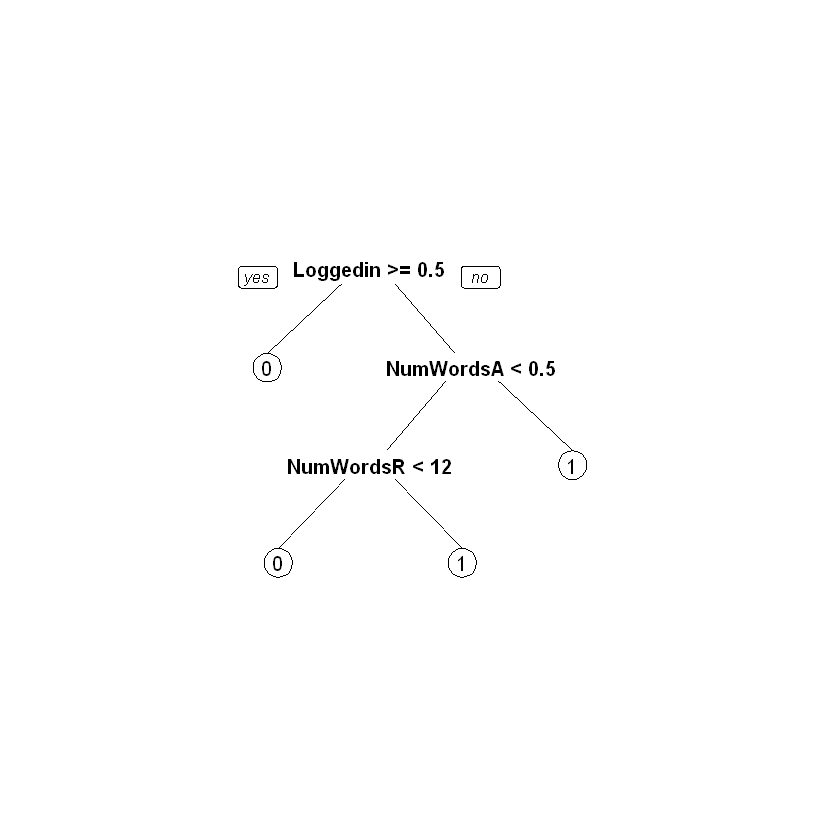

In [34]:
prp(wikiCART4)